##### Download Dataset from the following link
Images: https://openi.nlm.nih.gov/imgs/collections/NLMCXR_png.tgz

Report: https://openi.nlm.nih.gov/imgs/collections/NLMCXR_reports.tgz

FAQs: https://openi.nlm.nih.gov/faq

### Setting Up Data Locally

We will do all pre-processing Locally followed by training on Colab

In [7]:
import os
import tensorflow as tf
import xml.etree.ElementTree
import numpy as np

C:\Users\Cyborg\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [154]:
import pandas as pd 
import re
import matplotlib.pyplot as plt
from IPython.display import Image
from PIL import Image
from numpy import array
import string
import os
from PIL import Image
import glob
import pickle
from pickle import dump, load
from time import time
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [74]:
image_folder = 'E:\Medical data case study'
annotation_folder = 'E:\Medical data case study\ecgen-radiology'

In [92]:
## https://github.com/wisdal/diagnose-and-explain/blob/master/prepare_dataset.py

def extract_data():
    all_findings = []
    all_impressions = []
    all_img_names = []
    rids = []
    
    total_count = 0 # Count of reports available in the dataset
    no_image_count = 0 # Count of reports having no associated chest image
    no_impression_count = 0 # Count of reports having an empty "Impression" section
    no_findings_count = 0 # Count of reports having an empty "Findings" section

    # Storing impressions, findings and the image names in vectors
    for file in os.listdir(annotation_folder):
        total_count += 1
        file = os.path.abspath(annotation_folder) + '/' + file
        e = xml.etree.ElementTree.parse(file).getroot()

        rid = e.find('pmcId').get('id') # Report Id
        # We choose to ignore reports having no associated image
        image_id = e.find('parentImage')
        if image_id is None:
            no_image_count += 1
            continue

        image_id = image_id.get('id')
#         image_name = os.path.abspath('.') + '/' + image_id + '.png'
        image_name = image_folder + '/' + image_id + '.png'
        findings = ''
        impression = ''

        # Parsing "Impression" and "Findings"
        for element in e.findall('MedlineCitation/Article/Abstract/AbstractText'):
            if element.get('Label') == 'FINDINGS':
                findings = element.text
            if element.get('Label') == 'IMPRESSION':
                impression = element.text

        # Sanity check: Skip this report if it has an empty "Impression" section
        if findings is None:
            no_findings_count += 1
            #findings = 'No finding'
            continue
        if impression is None:
            no_impression_count += 1
            continue
        
        # Transforming findings and impressions into lists of sentences
        # https://stackoverflow.com/questions/21840389/python-regular-expression-remove-period-from-number-at-end-of-sentence
        findings = findings.replace("XXXX", "") #"XXXX" represents information anonymized
        findings=re.sub('((\d+)[\.])(?!([\d]+))','\g<2>',findings)
        findings = re.sub(" \d+", " ", findings)
#         sentences = findings.split('.')
        sentences = findings
#         del sentences[-1]
#         sentences = ['<start> ' + sentence + ' <end>' for sentence in sentences]
        sentences = ['<start> ' + sentences + ' <end>']
        findings = sentences

        impression = impression.replace("XXXX", "") #"XXXX" represents information anonymized
        impression=re.sub('((\d+)[\.])(?!([\d]+))','\g<2>',impression)
        impression = re.sub(" \d+", " ", impression)
#https://www.tutorialspoint.com/How-to-remove-specific-characters-from-a-string-in-Python
        impression=impression.replace("1", "")
#         sentences = impression.split('.')
#         del sentences[-1]
        sentences = impression
#         sentences = ['<start> ' + sentence + ' <end>' for sentence in sentences]
        sentences = ['<start> ' + sentences + ' <end>' ]
        impression = sentences

        #appending to vectors
        all_img_names.append(image_name)
        all_findings.append(findings)
        all_impressions.append(impression)
        rids.append(rid)

    print("Number of reports available:", total_count)
    print("Number of reports selected:", len(all_img_names))
    print("Number of reports not having images (skipped):", no_image_count)
    print("Number of reports with Impression section empty (skipped):", no_impression_count)
    print("Number of reports with Findings section empty:", no_findings_count)
    print("Total skipped:", no_image_count + no_impression_count + no_findings_count)

    return all_findings, all_impressions, all_img_names, rids

In [93]:
all_findings, all_impressions, all_img_names, report_id=extract_data()

Number of reports available: 3955
Number of reports selected: 3331
Number of reports not having images (skipped): 104
Number of reports with Impression section empty (skipped): 6
Number of reports with Findings section empty: 514
Total skipped: 624


In [94]:
## Converting Lists to Dataframe
## https://stackoverflow.com/questions/30522724/take-multiple-lists-into-dataframe
df = pd.DataFrame(
    { 'report_id':report_id,
        'findings': all_findings,
     'impressions': all_impressions,
     'image_names': all_img_names
    })

In [95]:
df.head(10)

,report_id,findings,impressions,image_names
0,1,[<start> The cardiac silhouette and mediastinu...,[<start> Normal chest x-. <end>],E:\Medical data case study/CXR1_1_IM-0001-3001...
1,10,[<start> The cardiomediastinal silhouette is w...,[<start> No acute cardiopulmonary process. <end>],E:\Medical data case study/CXR10_IM-0002-1001.png
2,100,[<start> Both lungs are clear and expanded. He...,[<start> No active disease. <end>],E:\Medical data case study/CXR100_IM-0002-1001...
3,1000,[<start> There is increased opacity within th...,[<start> Increased opacity in the right upper...,E:\Medical data case study/CXR1000_IM-0003-100...
4,1001,[<start> Interstitial markings are diffusely p...,[<start> Diffuse fibrosis. No visible focal ac...,E:\Medical data case study/CXR1001_IM-0004-100...
5,1003,[<start> Heart size and pulmonary vascularity ...,[<start> Retrocardiac soft tissue density. Th...,E:\Medical data case study/CXR1003_IM-0005-200...
6,1004,"[<start> The heart, pulmonary and mediastinum...",[<start> No acute cardiopulmonary disease. <end>],E:\Medical data case study/CXR1004_IM-0005-100...
7,1005,[<start> Cardiac and mediastinal contours are ...,[<start> No acute findings. <end>],E:\Medical data case study/CXR1005_IM-0006-100...
8,1006,[<start> The lungs appear clear. There are no ...,[<start> No acute cardiopulmonary disease. <end>],E:\Medical data case study/CXR1006_IM-0007-100...
9,1007,[<start> Trachea is midline. The cardiomediast...,[<start> No acute cardiopulmonary abnormalitie...,E:\Medical data case study/CXR1007_IM-0008-100...


In [96]:
len(df['report_id'].unique())

3331

In [97]:
print(df['findings'][3])
print("-"*50)
print(df['impressions'][3])

['<start> There is  increased opacity within the right upper lobe with possible mass and associated area of atelectasis or focal consolidation. The cardiac silhouette is within normal limits.  opacity in the left midlung overlying the posterior left th rib may represent focal airspace disease. No pleural effusion or pneumothorax. No acute bone abnormality. <end>']
--------------------------------------------------
['<start>  Increased opacity in the right upper lobe with  associated atelectasis may represent focal consolidation or mass lesion with atelectasis. Recommend chest CT for further evaluation.   opacity overlying the left th rib may represent focal airspace disease. <end>']


In [98]:
df.shape[0]

3331

In [99]:
df.head()

,report_id,findings,impressions,image_names
0,1,[<start> The cardiac silhouette and mediastinu...,[<start> Normal chest x-. <end>],E:\Medical data case study/CXR1_1_IM-0001-3001...
1,10,[<start> The cardiomediastinal silhouette is w...,[<start> No acute cardiopulmonary process. <end>],E:\Medical data case study/CXR10_IM-0002-1001.png
2,100,[<start> Both lungs are clear and expanded. He...,[<start> No active disease. <end>],E:\Medical data case study/CXR100_IM-0002-1001...
3,1000,[<start> There is increased opacity within th...,[<start> Increased opacity in the right upper...,E:\Medical data case study/CXR1000_IM-0003-100...
4,1001,[<start> Interstitial markings are diffusely p...,[<start> Diffuse fibrosis. No visible focal ac...,E:\Medical data case study/CXR1001_IM-0004-100...


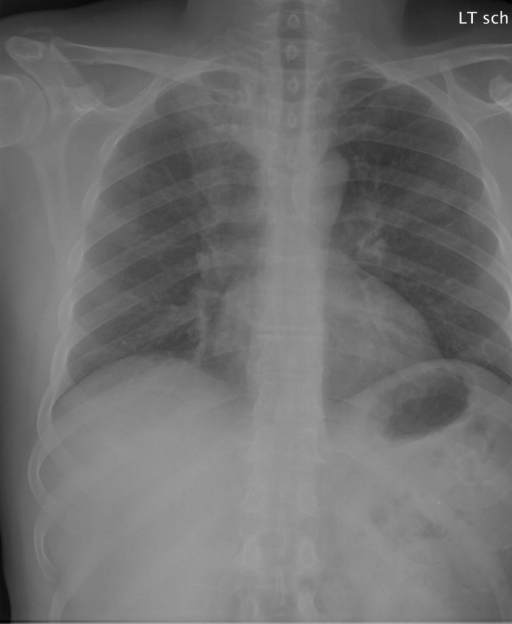

In [113]:
Image(filename=df['image_names'][i], width=300, height=300) 

In [123]:
### https://pythonadventures.wordpress.com/2011/04/04/get-the-size-dimension-of-an-image/
# for i in range(10):
#     image_file = df['image_names'][i]
#     im = Image.open(image_file)
#     print(im.size)   # return value is a tuple, ex.: (1200, 800)

#### We would take size of image as (512,624)
for details uncomment the above snippet and run

In [124]:
max(df['impressions'].apply(lambda x:len(x)))

1

In [130]:
def preprocess_image(image_path):
    # Convert all the images to size 299x299 as expected by the inception v3 model
    img = image.load_img(image_path, target_size=(512, 624))
    # Convert PIL image to numpy array of 3-dimensions
    x = image.img_to_array(img)
    # Add one more dimension
    x = np.expand_dims(x, axis=0)
    # preprocess the images using preprocess_input() from inception module
    x = preprocess_input(x)
    return x

In [127]:
# Load the inception v3 model
model = InceptionV3(weights='imagenet')

Instructions for updating:
keep_dims is deprecated, use keepdims instead
96116736/96112376 [==============================] - 107s 1us/step


In [145]:
# Create a new model, by removing the last layer (output layer) from the inception v3
model_new = Model(model.input, model.layers[-2].output)
# # model.add(Dense(4096))
# b=Dense(4096)(model)

In [149]:
# Function to encode a given image into a vector of size (2048, )
def encode(image):
    image = preprocess_image(image) # preprocess the image
    fea_vec = model_new.predict(image) # Get the encoding vector for the image
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshape from (1, 2048) to (2048, )
    return fea_vec
# Call the funtion to encode all the train images
# This will take a while on CPU - Execute this only once


In [150]:
# start = time()
# encoding_train = {}
# for img in tqdm(df['image_names']):
#     encoding_train[img] = encode(img)
# print("Time taken in seconds =", time()-start)

100%|████████████████████████████████████████████████████████████████████████████| 3331/3331 [1:28:55<00:00,  1.23s/it]


Time taken in seconds = 5335.879544019699


In [151]:
encoding_train[img].shape

(2048,)

In [155]:
# Save the bottleneck train features to disk
with open("./encoded_train_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_train, encoded_pickle)

In [156]:
train_features = load(open("./encoded_train_images.pkl", "rb"))
print('Photos: train=%d' % len(train_features))

Photos: train=3331


In [158]:
corpus=''
for i in df['impressions']:
    corpus+=str(i)

In [160]:
len(corpus)

254566

In [162]:
X=df['image_names']
y=df['impressions']
X_train, X_test, y_train, y_test = train_test_split(X,y , test_size=0.20, random_state=42)

In [170]:
def transform_input(all_findings, all_impressions, max_paragraph_length, max_sentence_length):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')

    findings_texts = [' '.join(findings) for findings in all_findings]
    impressions_texts = [' '.join(impression) for impression in all_impressions]
    tokenizer.fit_on_texts(findings_texts + impressions_texts)
    all_findings_seq = [tokenizer.texts_to_sequences(findings) for findings in all_findings]
    all_impressions_seq = [tokenizer.texts_to_sequences(impression) for impression in all_impressions]

    tokenizer.word_index['<pad>'] = 0

    # Adding empty sentence seqs to each paragraph to have a fixed length for each
    for findings in all_findings_seq:
        while len(findings) < max_paragraph_length:
            findings.append([0])
        if len(findings) > max_paragraph_length:
            del findings[max_paragraph_length:]

    for impressions in all_impressions_seq:
        while len(impressions) < max_paragraph_length:
            impressions.append([0])
        if len(impressions) > max_paragraph_length:
            del impressions[max_paragraph_length:]

    # Padding sequences
    pad_sequences = tf.keras.preprocessing.sequence.pad_sequences
    findings_vector = [pad_sequences(findings, padding='post', maxlen=max_sentence_length) for findings in all_findings_seq]
    impressions_vector = [pad_sequences(impressions, padding='post', maxlen=max_sentence_length) for impressions in all_impressions_seq]

    #print(findings_vector[0])
    #print(impressions_vector[0])

    # Combining findings and impressions
    for i in range(len(findings_vector)):
        findings_vector[i] = np.concatenate((findings_vector[i], impressions_vector[i]))
    # Now, for a given batch "i", we can retrieve impressions = findings[i, max_paragraph_length:]
    #print(findings_vector[0])

    return tokenizer, findings_vector

In [171]:
max_paragraph_length=5
max_sentence_length=18
tokenizer, findings_vector=transform_input(all_findings, all_impressions, max_paragraph_length, max_sentence_length)

In [172]:
img_name_train, img_name_test, findings_train, findings_test = train_test_split(all_img_names, findings_vector, test_size = 0.2, random_state = 0)

In [174]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize_images(img, (512, 624))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path
load_image(df['image_names'][0])

(<tf.Tensor 'sub_1:0' shape=(512, 624, 3) dtype=float32>,
 'E:\\Medical data case study/CXR1_1_IM-0001-3001.png')

In [175]:
def map_func(img_name, findings):
    img, img_path = load_image(img_name)
    img = tf.expand_dims(img, 0)
    img_tensor = inception_model(img)
    img_tensor = tf.reshape(img_tensor,
                            (-1, img_tensor.shape[3]))

    return img_tensor, findings

def _set_shapes(images, findings):
    # Statically set tensors dimensions
    print(images.get_shape(), findings.get_shape())
    images.set_shape(tf.TensorShape([ATTENTION_FEATURES_SHAPE, FEATURES_SHAPE]))
    findings.set_shape(findings.get_shape().merge_with(
            tf.TensorShape([MAX_PARAGRAPH_LENGTH + MAX_PARAGRAPH_LENGTH, MAX_SENTENCE_LENGTH])))
    return images, findings